In [117]:
#The purpose of this file is to perform an analysis of the chinese voter demographic swings across electorates in the 2023 Australian Election
#This is to discover whether or not the chinese vote swung towards one side or another in any statistically significant way, potentially as a result of the outspoken anti-China rhetoric coming from the Coalition Government at the time

#First, import relevant packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from mylibrary import append_gis
import sys
%matplotlib inline

In [118]:
# Import abs data - chinese population
input_a = pd.read_csv('./data_files/chinese_asian_pop.csv', header=6)

# Check the table
print(input_a.dtypes)
input_a

2-digit level ANCP Ancestry Multi Response     object
Chinese Asian                                  object
Total                                         float64
Unnamed: 3                                    float64
dtype: object


,2-digit level ANCP Ancestry Multi Response,Chinese Asian,Total,Unnamed: 3
0,SA1 (UR),NaN,NaN,NaN
1,10201102801,0,0.0,NaN
2,10201102802,7,7.0,NaN
3,10201102803,5,5.0,NaN
4,10201102804,4,4.0,NaN
...,...,...,...,...
61845,Total,1414549,1414549.0,NaN
61846,"Dataset: Census of Population and Housing, 202...",NaN,NaN,NaN
61847,INFO,Cells in this table have been randomly adjuste...,NaN,NaN
61848,"Copyright Commonwealth of Australia, 2021, see...",NaN,NaN,NaN


In [119]:
# Clean up: Drop unused columns
input_a.drop(columns=['Total','Unnamed: 3'], inplace=True)

# Rename columns then drop the first row and last rows
    # retrieve old column names
column_name1 = input_a.columns[0]
column_name2 = input_a.columns[1]
    # set new column name
input_a.rename(columns={column_name1:'sa1',column_name2:'chinese_pop'},inplace=True)
    # delete first and last rows
input_a.drop(0, axis=0, inplace=True)
input_a.reset_index(drop=True, inplace=True) #reset index
input_a.drop(range(61844,len(input_a)), axis=0, inplace=True)

# convert chinese_pop column to float
input_a['chinese_pop'] = input_a['chinese_pop'].astype(np.float64)
print(input_a.dtypes)
input_a

sa1             object
chinese_pop    float64
dtype: object


,sa1,chinese_pop
0,10201102801,0.0
1,10201102802,7.0
2,10201102803,5.0
3,10201102804,4.0
4,10201102805,0.0
...,...,...
61839,90104100406,0.0
61840,90104100407,0.0
61841,90104100408,0.0
61842,99999949999,0.0


In [120]:
# Now import abs data - total population
input_b = pd.read_csv('./data_files/ancestry_firstresponse_sa1.csv', header=6)

# Check the table
print(input_b.dtypes)
input_b

1-digit level ANC1P Ancestry 1st Response     object
Oceanian                                      object
North-West European                          float64
Southern and Eastern European                float64
North African and Middle Eastern             float64
South-East Asian                             float64
North-East Asian                             float64
Southern and Central Asian                   float64
Peoples of the Americas                      float64
Sub-Saharan African                          float64
Supplementary codes                          float64
Not stated                                   float64
Unnamed: 12                                  float64
dtype: object


,1-digit level ANC1P Ancestry 1st Response,Oceanian,North-West European,Southern and Eastern European,North African and Middle Eastern,South-East Asian,North-East Asian,Southern and Central Asian,Peoples of the Americas,Sub-Saharan African,Supplementary codes,Not stated,Unnamed: 12
0,SA1 (UR),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10201102801,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,10201102802,156,390.0,27.0,0.0,6.0,3.0,3.0,0.0,0.0,7.0,17.0,NaN
3,10201102803,155,419.0,31.0,7.0,0.0,6.0,0.0,4.0,0.0,0.0,15.0,NaN
4,10201102804,48,157.0,0.0,3.0,3.0,5.0,0.0,0.0,0.0,0.0,16.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61845,Total,5724641,11203380.0,1940843.0,642686.0,848912.0,1480255.0,1471926.0,179213.0,216143.0,130625.0,1584164.0,NaN
61846,"Dataset: Census of Population and Housing, 202...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61847,INFO,Cells in this table have been randomly adjuste...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61848,"Copyright Commonwealth of Australia, 2021, see...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
#Clean up: Rename first column
    # retrieve old column name
initial_column_name = input_b.columns[0]
    # set new column name
input_b.rename(columns={initial_column_name:'sa1'},inplace=True)

# Delete first and last rows
input_b.drop(0, axis=0, inplace=True)
input_b.reset_index(drop=True, inplace=True) #reset index
input_b.drop(range(61844,len(input_b)), axis=0, inplace=True)
input_b

#Create total rows - one for total population of the SA1;
input_b['total_pop'] = input_b.iloc[:,1:12].sum(axis=1)
#and one for the diverse population - excluding european, oceanic (includes "Australian"), and "not stated" categories
input_b['diversity_pop'] = input_b.iloc[:,4:11].sum(axis=1)

#Drop unused columns
input_b = input_b[['sa1','total_pop','diversity_pop']]
input_b

C:\Users\jacks\AppData\Local\Temp\ipykernel_12332\3502944523.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  input_b['total_pop'] = input_b.iloc[:,1:12].sum(axis=1)


,sa1,total_pop,diversity_pop
0,10201102801,0.0,0.0
1,10201102802,453.0,19.0
2,10201102803,482.0,17.0
3,10201102804,184.0,11.0
4,10201102805,231.0,10.0
...,...,...,...
61839,90104100406,0.0,0.0
61840,90104100407,235.0,3.0
61841,90104100408,0.0,0.0
61842,99999949999,12.0,4.0


In [122]:
# Combine input tables
input_df = pd.merge(input_a,input_b, on='sa1', how='left')


In [123]:
# Need to also explore whether any correlation can be explained by other variables
# Primarily, check whether the demographics of electorates with high chinese population skew in other consistent ways that could explain the swing
# For this, we'll conduct some tests on correlation between demographic factors
# First, import relevant SA1 demographic data from ABS
# Age
age_sa1_df = pd.read_csv('./data_files/age_10y_sa1.csv', header=6)
# Sex
sex_sa1_df = pd.read_csv('./data_files/sex_sa1.csv', header=6)
# income
income_sa1_df = pd.read_csv('./data_files/weekly_income_sa1.csv', header=6)

C:\Users\jacks\AppData\Local\Temp\ipykernel_12332\393343758.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  income_sa1_df = pd.read_csv('./data_files/weekly_income_sa1.csv', header=6)


In [124]:
#Clean up all new dataframes
dataframes = [age_sa1_df,sex_sa1_df,income_sa1_df]

for frame in dataframes:
    #Clean up: Rename first column
    # retrieve old column name
    initial_column_name = frame.columns[0]
    # set new column name
    frame.rename(columns={initial_column_name:'sa1'},inplace=True)

    # Delete first and last rows
    frame.drop(0, axis=0, inplace=True)
    frame.reset_index(drop=True, inplace=True) #reset index
    frame.drop(range(61844,len(frame)), axis=0, inplace=True)

    # Delete last column
    last_col = frame.columns[-1]
    frame.drop(last_col, axis=1, inplace=True)

    # Convert first column data type after SA1 to a float
        #retrieve column name
    col_name = frame.columns[1]
    frame[col_name] = frame[col_name].astype(np.float64)
    

In [125]:
# Alter each new data frame for addition into primary input_b frame
# Starting with age - need to create single summary stat for each SA1 - we will go with median age
# Assume each 10 year band is middle of band (ie 10-19 years = 15)
band_mid_age = np.array([5,15,25,35,45,55,65,75,85,95,105])

# Assign custom function to determine average age for a row
def weighted_age_from_buckets(x,midpoints):
    age_multiples = midpoints * x.iloc[1:12]
    #ensure average is NaN if total SA1 population is 0 - No longer relevant
    # if x.iloc[12] == 0:
    #     average = np.NaN
    # else:
    average = age_multiples.sum()

    return average

# Apply the custom function to the whole df
age_sa1_df['weighted_age'] = age_sa1_df.apply(weighted_age_from_buckets, args=(band_mid_age,), axis=1)


In [126]:
# Income - use same function method as with age - negative income stated as 0, max income arbitrarily chosen as 4000
band_mid_income = np.array([0,0,75,225,350,450,575,725,900,1125,1375,1625,1875,2500,3250,4000])

# Assign custom function to determine average age for a row
def weighted_income_from_buckets(x,midpoints):
    income_multiples = midpoints * x.iloc[1:17]
    #ensure average is NaN if total SA1 population is 0 - No longer needed here
    # if x.iloc[12] == 0:
    #     average = np.NaN
    # else:
    average = income_multiples.sum()

    return average

# Apply the custom function to the whole df
income_sa1_df['weighted_income'] = income_sa1_df.apply(weighted_income_from_buckets, args=(band_mid_income,), axis=1)



In [127]:
#Append relevant data to the main df in stages
demo_df_1 = pd.merge(input_df,age_sa1_df[['sa1','weighted_age']], on='sa1', how='left')
demo_df_2 = pd.merge(demo_df_1,sex_sa1_df[['sa1','Male','Female']], on='sa1', how='left')
demo_df = pd.merge(demo_df_2,income_sa1_df[['sa1','weighted_income']], on='sa1', how='left')

demo_df.head()

,sa1,chinese_pop,total_pop,diversity_pop,weighted_age,Male,Female,weighted_income
0,10201102801,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10201102802,7.0,453.0,19.0,25645.0,286.0,323.0,541675.0
2,10201102803,5.0,482.0,17.0,27585.0,321.0,318.0,667775.0
3,10201102804,4.0,184.0,11.0,10450.0,105.0,124.0,230900.0
4,10201102805,0.0,231.0,10.0,12365.0,151.0,151.0,242025.0


In [128]:
# Append SA1 geometry to the complete df
demo_gdf = append_gis(demo_df,'sa1','SA1')

# Convert geometry to centroids
demo_gdf['sa1_centroids'] = demo_gdf['geometry'].centroid
# And drop geometry
demo_gdf.drop(columns='geometry', inplace=True)
# Set new column as the active geometry column
demo_gdf.set_geometry('sa1_centroids', inplace=True)
demo_gdf.head()

C:\Users\jacks\AppData\Local\Temp\ipykernel_12332\169708914.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  demo_gdf['sa1_centroids'] = demo_gdf['geometry'].centroid


,sa1,chinese_pop,total_pop,diversity_pop,weighted_age,Male,Female,weighted_income,sa1_centroids
0,10201102801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (151.42844 -33.46232)
1,10201102802,7.0,453.0,19.0,25645.0,286.0,323.0,541675.0,POINT (151.41872 -33.46900)
2,10201102803,5.0,482.0,17.0,27585.0,321.0,318.0,667775.0,POINT (151.43238 -33.46794)
3,10201102804,4.0,184.0,11.0,10450.0,105.0,124.0,230900.0,POINT (151.42589 -33.47034)
4,10201102805,0.0,231.0,10.0,12365.0,151.0,151.0,242025.0,POINT (151.42131 -33.47295)


In [129]:
# Import electoral data
edf = pd.read_csv('./data_files/HouseTcpByCandidateByVoteTypeDownload-27966.csv', header=1)
# Check the table
edf.head()

,StateAb,DivisionID,DivisionNm,CandidateID,Surname,GivenNm,BallotPosition,Elected,HistoricElected,PartyAb,PartyNm,OrdinaryVotes,AbsentVotes,ProvisionalVotes,PrePollVotes,PostalVotes,TotalVotes,Swing
0,ACT,318,Bean,36231,SMITH,David,3,Y,Y,ALP,Australian Labor Party,53845,1067,154,1554,5315,61935,5.43
1,ACT,318,Bean,37198,HIATT,Jane,6,N,N,LP,Liberal,31489,598,96,1051,3225,36459,-5.43
2,ACT,101,Canberra,36241,HOLLO,Tim,5,N,N,GRN,The Greens,29081,661,123,1547,3489,34901,37.80
3,ACT,101,Canberra,36228,PAYNE,Alicia,6,Y,Y,ALP,Australian Labor Party,47414,1012,204,2311,6480,57421,62.20
4,ACT,102,Fenner,36234,LEIGH,Andrew,1,Y,Y,ALP,Australian Labor Party,52109,1055,202,1484,5116,59966,5.13


In [130]:
# Manipulate electoral data into desired form - different columns for different parties
# First, drop unwanted columns
edf_transform = edf.drop(edf.columns[[1,3,6,8,10,11,12,13,14,15]], 
                         axis=1,
                         inplace=False)

# Next, concatenate candidate name, drop old name columns
edf_transform['CandidateNm'] = edf_transform['GivenNm'].str.cat(edf_transform['Surname'], sep=' ')
edf_transform.drop(columns=['Surname','GivenNm'], inplace=True)

# Pivot table around party - Create "Elected" and "Not Elected" columns
edf_transform = edf_transform.pivot_table(index='DivisionNm', columns='Elected', aggfunc='max')
# Rename columns and reset index
edf_transform.columns = edf_transform.columns.map('_'.join)
edf_transform.reset_index(col_level=1, inplace=True)
edf_transform.head()
# Reformat and re-order
edf_transform['WinnerVotePct'] = (edf_transform['TotalVotes_Y']/(edf_transform['TotalVotes_N'] + edf_transform['TotalVotes_Y'])*100).apply(lambda x: round(x,2))
edf_transform.drop(['TotalVotes_Y','TotalVotes_N', 'Swing_N', 'StateAb_N'], inplace=True, axis=1)
desired_order = ['DivisionNm','StateAb_Y','PartyAb_Y','CandidateNm_Y','WinnerVotePct','Swing_Y','PartyAb_N','CandidateNm_N']
edf_transform = edf_transform.reindex(columns=desired_order)
# Rename columns
edf_transform.columns = ['Division','State','Winner','Winning_Candidate','Win_Pct','Swing','Runner_up','Runner_up_Candidate']
# Add marginality column - for further analysis
edf_transform['Marginality'] = edf_transform['Win_Pct'].apply(lambda x: 'Y' if x<56 else 'N')

edf_transform.head()

,Division,State,Winner,Winning_Candidate,Win_Pct,Swing,Runner_up,Runner_up_Candidate,Marginality
0,Adelaide,SA,ALP,Steve GEORGANAS,61.91,3.73,LP,Amy GRANTHAM,N
1,Aston,VIC,LP,Alan TUDGE,52.81,-7.32,ALP,Mary DOYLE,Y
2,Ballarat,VIC,ALP,Catherine KING,62.97,2.74,LP,Ben GREEN,N
3,Banks,NSW,LP,David COLEMAN,53.20,-3.06,ALP,Zhi SOON,Y
4,Barker,SA,LP,Tony PASIN,66.62,-2.32,ALP,Mark BRAES,N


In [131]:
# Append geometric data
elect_gdf = append_gis(edf_transform,'Division','federal electorate')
# Assign the active geometry

elect_gdf.head(3)

,Division,geometry,State,Winner,Winning_Candidate,Win_Pct,Swing,Runner_up,Runner_up_Candidate,Marginality
0,Adelaide,"POLYGON Z ((138.63816 -34.87041 0.00000, 138.6...",SA,ALP,Steve GEORGANAS,61.91,3.73,LP,Amy GRANTHAM,N
1,Aston,"POLYGON Z ((145.34762 -37.85941 0.00000, 145.3...",VIC,LP,Alan TUDGE,52.81,-7.32,ALP,Mary DOYLE,Y
2,Ballarat,"POLYGON Z ((143.82315 -38.05579 0.00000, 143.8...",VIC,ALP,Catherine KING,62.97,2.74,LP,Ben GREEN,N


In [132]:
# Aggregate SA1 data under Electorate data
# Merge the electorate geometry onto demo_gdf - Assigning based on whether the SA1 Centroid is contained within the geometry
merged_gdf = gpd.sjoin(elect_gdf[['geometry']], demo_gdf, how='right', op='contains')
# Drop the now-redundant centroid and sa1 data
merged_gdf.drop(columns=['sa1','sa1_centroids'], inplace=True)

# Aggregate under new column ('index_left')
agg_gdf = merged_gdf.groupby('index_left').agg({'chinese_pop':'sum','total_pop':'sum','diversity_pop':'sum','weighted_age':'sum','Male':'sum','Female':'sum','weighted_income':'sum'},skipna=True)

# Now combine the two dataframes in one based on the index value
full_df = pd.merge(elect_gdf, agg_gdf, left_index=True, right_index=True)

full_df.head()

c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3301: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\jacks\AppData\Local\Temp\ipykernel_12332\2707759143.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4283
Right CRS: EPSG:7844

  merged_gdf = gpd.sjoin(elect_gdf[['geometry']], demo_gdf, how='right', op='contains')


,Division,geometry,State,Winner,Winning_Candidate,Win_Pct,Swing,Runner_up,Runner_up_Candidate,Marginality,chinese_pop,total_pop,diversity_pop,weighted_age,Male,Female,weighted_income
0.0,Adelaide,"POLYGON Z ((138.63816 -34.87041 0.00000, 138.6...",SA,ALP,Steve GEORGANAS,61.91,3.73,LP,Amy GRANTHAM,N,16398.0,167530.0,58265.0,7814615.0,98219.0,99358.0,167954500.0
1.0,Aston,"POLYGON Z ((145.34762 -37.85941 0.00000, 145.3...",VIC,LP,Alan TUDGE,52.81,-7.32,ALP,Mary DOYLE,Y,22576.0,129676.0,45950.0,6539555.0,78005.0,81179.0,126348800.0
2.0,Ballarat,"POLYGON Z ((143.82315 -38.05579 0.00000, 143.8...",VIC,ALP,Catherine KING,62.97,2.74,LP,Ben GREEN,N,2196.0,110226.0,7959.0,6270735.0,74180.0,78001.0,111076350.0
3.0,Banks,"POLYGON Z ((151.12967 -33.97363 0.00000, 151.1...",NSW,LP,David COLEMAN,53.20,-3.06,ALP,Zhi SOON,Y,32790.0,138664.0,65917.0,6626960.0,79741.0,82946.0,130156150.0
4.0,Barker,"MULTIPOLYGON Z (((141.00296 -34.02189 0.00000,...",SA,LP,Tony PASIN,66.62,-2.32,ALP,Mark BRAES,N,1182.0,120243.0,6813.0,7481705.0,86568.0,84981.0,112023775.0


In [133]:
# Convert main datapoints to useful measures
# Chinese population - express as a percentage
full_df['pct_chinese'] = (full_df['chinese_pop']/full_df['total_pop']*100).apply(lambda x: round(x,1))

# Same for diverse population measure
full_df['pct_diverse'] = (full_df['diversity_pop']/full_df['total_pop']*100).apply(lambda x: round(x,1))

# For age and income, obtain an average for each electorate
full_df['average_age'] = full_df['weighted_age']/full_df['total_pop']
full_df['average_income'] = full_df['weighted_income']/full_df['total_pop']

# For gender data, convert population counts to a single M/F ratio
full_df['m_f_ratio'] = full_df['Male']/full_df['Female']
    # replace infinite and zero values with NaN
full_df['m_f_ratio'] = full_df['m_f_ratio'].replace({np.inf:np.nan, 0:np.nan})


In [134]:
# Now explore the data - start with a chart comparing chinese pop % to swing towards Labor
# Create new df with relevant info - drop any electorate where the TCP is not between Labor and The Coalition
corr_df = pd.DataFrame(full_df.copy().loc[(full_df['Winner'].isin(['ALP','LP','LNP','NP'])) & (full_df['Runner_up'].isin(['ALP','LP','LNP','NP']))])
corr_df.reset_index(drop=True, inplace=True) #reset index

# Calculate dependent variable - swing TO Labor
# Set up conditional to be used in apply method
def swing_direction(row):
    if row['Winner'] == 'ALP':
        return row['Swing']
    else:
        return -row['Swing']

# Apply the conditional 
corr_df['Swing_to_Lab'] = corr_df.apply(swing_direction, axis=1)

# Drop unnecessary columns
corr_df.drop(corr_df.columns[[0,1,3,4,5,6,7,8,10,11,12,13,14,15,16]], axis=1, inplace=True)

corr_df.head()

,State,Marginality,pct_chinese,pct_diverse,average_age,average_income,m_f_ratio,Swing_to_Lab
0,SA,N,9.8,34.8,46.646063,1002.533875,0.988536,3.73
1,VIC,Y,17.4,35.4,50.429956,974.342207,0.960901,7.32
2,VIC,N,2.0,7.2,56.889799,1007.714605,0.951013,2.74
3,NSW,Y,23.6,47.5,47.791496,938.644133,0.961360,3.06
4,SA,N,1.0,5.7,62.221543,931.644877,1.018675,2.32


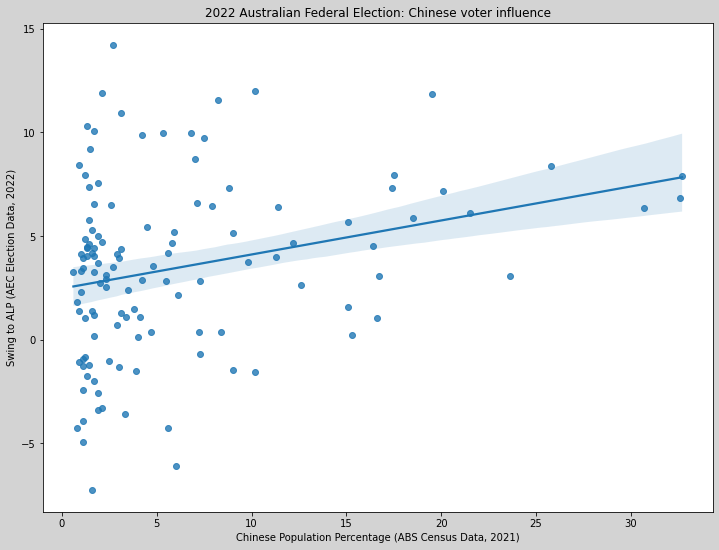

In [135]:
# Plot primary chinese population relationship on scatterplot - not accounting for confounding factors yet
# Initialise figure size
plt.figure(figsize=(12,9), facecolor='lightgrey')

# Plot with regression line with seaborn
sns.regplot(x='pct_chinese', y='Swing_to_Lab', data=corr_df)

# Add labels
plt.title('2022 Australian Federal Election: Chinese voter influence')
plt.xlabel('Chinese Population Percentage (ABS Census Data, 2021)')
plt.ylabel('Swing to ALP (AEC Election Data, 2022)')

# Save figure to file
plt.savefig('./outputs/swing_by_pct_chinese', dpi=300, bbox_inches = 'tight')
# Output inline
plt.show()

In [136]:
# Perform linear regression to get numerical values backing up the visualisation
# Define variables
X = corr_df[['pct_chinese']]
y = corr_df['Swing_to_Lab']

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Initialise and fit model
lreg = LinearRegression()
lreg.fit(X_train, y_train)

# Make predictions
y_pred = lreg.predict(X_test)

# Explain and Evaluate model
trend = lreg.coef_
intercept = lreg.intercept_
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation
print('The Linear Regression has a coefficient of ', round(trend[0],2))
print('Mean Squared Error:', round(mse,2))
print('R-squared:', round(r2,2))

# Also check Pearson Correlation Coefficient
correlation = np.corrcoef(corr_df['pct_chinese'],corr_df['Swing_to_Lab'])
print('\nPearson Correlation Coefficient: ', round(correlation[0,1],2))


The Linear Regression has a coefficient of  0.16
Mean Squared Error: 8.53
R-squared: 0.16

Pearson Correlation Coefficient:  0.27


In [137]:
# Save the above output to file
# Save the current standard output
original_stdout = sys.stdout

# Redirect the standard output to a variable
with open('./outputs/chinese_pop_only_regression.txt', 'w') as file:
    sys.stdout = file

    # Print evaluation
    print('------ Linear Regression and Pearson measurement of the correlation between Chinese Population Percentage of an electorate and the electorate swing towards Labor ------')
    print('\n')
    print('The Linear Regression has a coefficient of ', round(trend[0],2))
    print('Mean Squared Error:', round(mse,2))
    print('R-squared:', round(r2,2))

    # Also check Pearson Correlation Coefficient
    print('\nPearson Correlation Coefficient: ', round(correlation[0,1],2))


# Reset the standard output to the original
sys.stdout = original_stdout


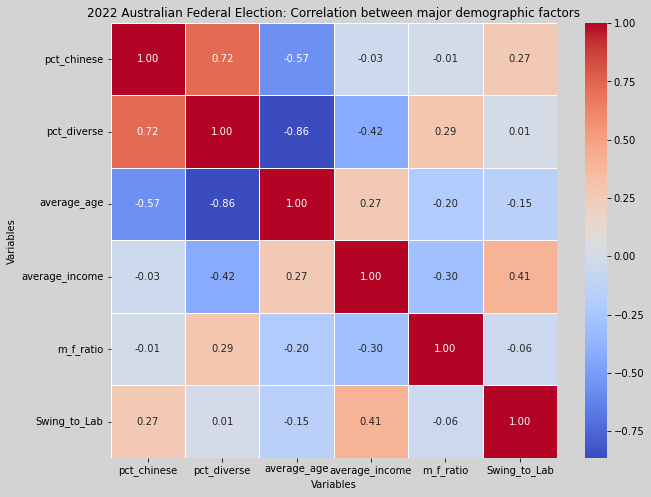

In [138]:
# Now we check the other primary variables we've imported to see if there are significant correlations/collinearities
    # For if all correlations to be visualised
correlation_matrix = corr_df.corr()
    # For if only chinese correlation to be visualised
#correlation_matrix = pd.DataFrame(corr_df.corr().iloc[0,:])


#Set up seaborn plot
plt.figure(figsize=(10,8), facecolor='lightgrey')

# Create a heatmap with values
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Add labels
plt.title('2022 Australian Federal Election: Correlation between major demographic factors')
plt.xlabel('Variables')
plt.ylabel('Variables')
# Save the plot
plt.savefig('./outputs/correlation_matrix', dpi=300, bbox_inches = 'tight')

# Display the plot
plt.show()

As expected, there is a significant correlation between population diversity and chinese population in an electorate, which needs to be accounted for. There is also a sizable correlation with the average age - but as Australia's highly-targeted immigration program favours younger adults, and these immigrant groups tend to settle in concentrated areas, the age correlation is assumed to be an associated effect of diversity (supported by very high collinearity between average age and diversity).

However, there is a very low correlation between the diverse population size and the swing to Labor, which supports the conclusion that the swing to Labor among chinese voters was due to factors unique to them.

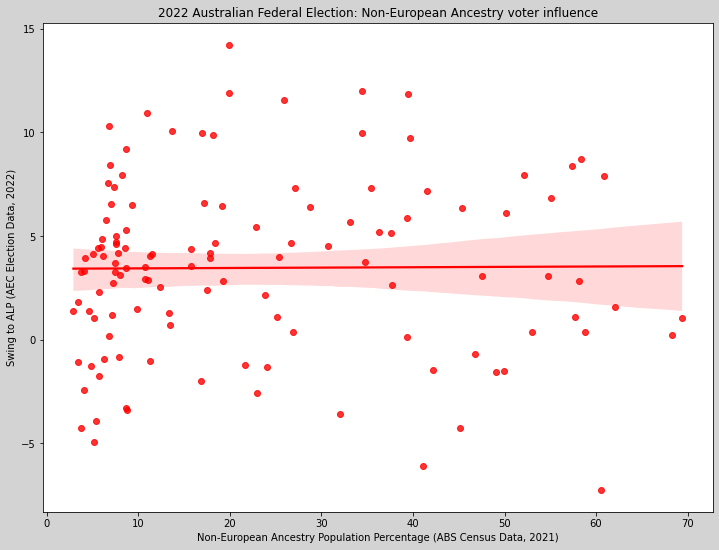

In [139]:
# Plot the relationship between pct_diverse and vote swings - to visualise how it might impact our conclusions
# Initialise figure size
plt.figure(figsize=(12,9), facecolor='lightgrey')

# Plot with regression line with seaborn
sns.regplot(x='pct_diverse', y='Swing_to_Lab', data=corr_df, color='red')

# Add labels
plt.title('2022 Australian Federal Election: Non-European Ancestry voter influence')
plt.xlabel('Non-European Ancestry Population Percentage (ABS Census Data, 2021)')
plt.ylabel('Swing to ALP (AEC Election Data, 2022)')

# Save figure to file
plt.savefig('./outputs/swing_by_pct_non-european', dpi=300, bbox_inches = 'tight')
# Output inline
plt.show()

In [140]:
# Perform a linear regression with pct_diverse included
# Define variables
X = corr_df[['pct_chinese','pct_diverse']]
y = corr_df['Swing_to_Lab']

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Initialise and fit model
lreg = LinearRegression()
lreg.fit(X_train, y_train)

# Make predictions
y_pred = lreg.predict(X_test)

# Explain and Evaluate model
trend = lreg.coef_
intercept = lreg.intercept_
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Print evaluation
print('The Linear Regression has a coefficient of ', round(trend[0],2),' for the chinese population contribution')
print('The Linear Regression has a coefficient of ', round(trend[1],2),' for the Non-European population contribution')
print('Mean Squared Error:', round(mse,2))
print('R-squared:', round(r2,2))

# Also check Pearson Correlation Coefficients
chinese_correlation = np.corrcoef(corr_df['pct_chinese'],corr_df['Swing_to_Lab'])
diverse_correlation = np.corrcoef(corr_df['pct_diverse'],corr_df['Swing_to_Lab'])
print('\nPearson Correlation Coefficient - Chinese population: ', round(chinese_correlation[0,1],2))
print('Pearson Correlation Coefficient - Non-European population: ', round(diverse_correlation[0,1],2))

The Linear Regression has a coefficient of  0.29  for the chinese population contribution
The Linear Regression has a coefficient of  -0.07  for the Non-European population contribution
Mean Squared Error: 4.98
R-squared: 0.51

Pearson Correlation Coefficient - Chinese population:  0.27
Pearson Correlation Coefficient - Non-European population:  0.01


In [141]:
# Save the above output to file
# Save the current standard output
original_stdout = sys.stdout

# Redirect the standard output to a variable
with open('./outputs/multi-pop_regression.txt', 'w') as file:
    sys.stdout = file
    
    print('------ Linear Regression and Pearson measurement of the correlation between Chinese and Non-European Population Percentages of an electorate and the electorate swing towards Labor ------')
    print('\n')
    print('The Linear Regression has a coefficient of ', round(trend[0],2),' for the chinese population contribution')
    print('The Linear Regression has a coefficient of ', round(trend[1],2),' for the Non-European population contribution')
    print('Mean Squared Error:', round(mse,2))
    print('R-squared:', round(r2,2))

    # Also check Pearson Correlation Coefficients
    print('\nPearson Correlation Coefficient - Chinese population: ', round(chinese_correlation[0,1],2))
    print('Pearson Correlation Coefficient - Non-European population: ', round(diverse_correlation[0,1],2))

# Reset the standard output to the original
sys.stdout = original_stdout
